In [1]:
import numpy as np
import pickle
import LoadMnist
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
matplotlib.rc('font', **{'size' : 16})

ImportError: cannot import name 'LayerNormalization'

#### Load 20k samples

In [ ]:
trainX, trainY, testX, testY = LoadMnist.GetData(128, 50000)

In [ ]:
trainX.shape, trainY.shape 

In [ ]:
trainY # Label - actual number after sequencing

In [ ]:
trainX[0]

In [ ]:
np.unique(trainX[:,:,0]) # There are various numbers except -1,0,1

In [ ]:
img_trainX = np.cumsum(trainX,axis=1) # Save cumsum of columns
img_trainX[0]

In [ ]:
trainX[:,:,0].shape

In [ ]:
img_trainX[0,:,:]

In [ ]:
plt.plot(img_trainX[1,:,0], img_trainX[1,:,1])

In [ ]:
# One hot encoder
trainY = to_categorical(trainY)
testY  = to_categorical(testY)
print(trainX.shape, testX.shape, trainY.shape, testY.shape)
print(trainY[0])
print(trainY[1])

In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainY.shape[1]
print("n_timesteps: ", n_timesteps)
print("n_features: ", n_features)
print("n_outputs: ", n_outputs)

In [ ]:
inputs = keras.Input(shape=(128,2)) # shape=(None, 128, 2)

In [ ]:
x = Conv1D(filters=150, kernel_size=3, input_shape=(n_timesteps,n_features))(inputs)
x = Conv1D(filters=100, kernel_size=3)(x)
x = Dropout(0.6)(x)
x = Conv1D(filters=50, kernel_size=3)(x)
x = Dropout(0.5)(x)
x = Conv1D(filters=20, kernel_size=3)(x)
x = Dropout(0.3)(x)
x = Flatten()(x)

In [ ]:
#dense = layers.Dense(100)

In [ ]:
x = Dense(100, activation = 'relu')(x) # TensorShape([None, 100])

In [ ]:
embeddings = layers.Dense(2)(x) #TensorShape([None, 128, 2])

In [ ]:
model_embeddings = keras.Model(inputs=inputs, outputs=embeddings)

In [ ]:
model_embeddings.summary()

In [ ]:
outputs = Dense(10, activation='softmax')(embeddings)

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs, name="test_model")

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [2]:
history = model.fit(trainX, trainY, epochs=300, batch_size=1500, validation_data=(testX,testY))

NameError: name 'model' is not defined

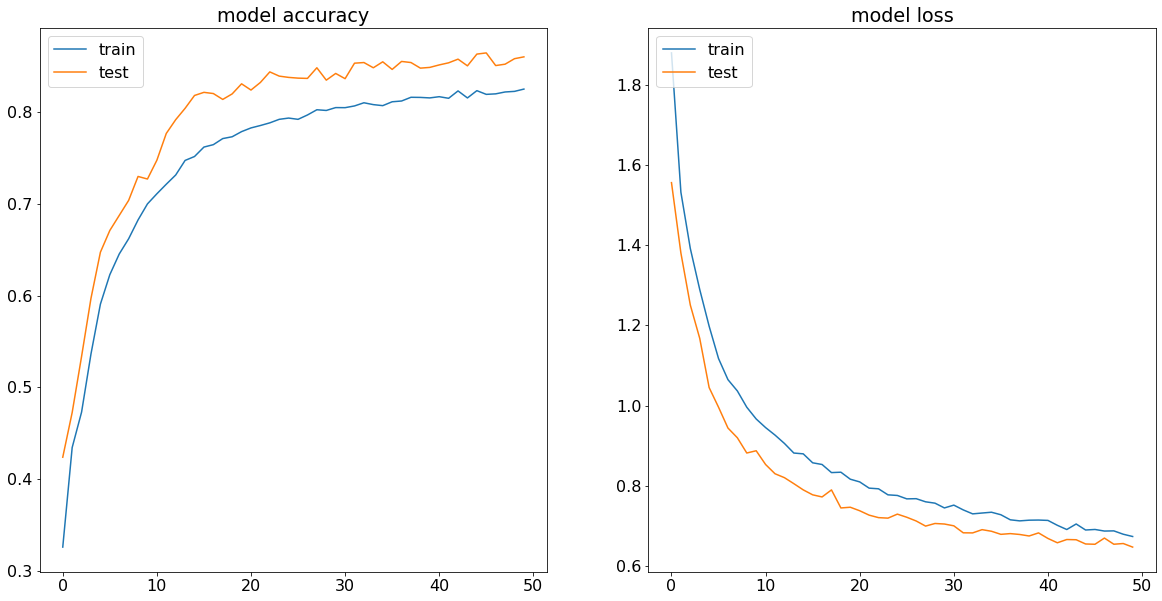

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
#ax1.ylabel('accuracy')
#ax1.xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
#ax2.ylabel('loss')
#ax2.xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')

In [27]:
model.summary()

Model: "test_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 2)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 126, 150)          1050      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 124, 100)          45100     
_________________________________________________________________
dropout (Dropout)            (None, 124, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 122, 50)           15050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 122, 50)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 120, 20)           3

In [28]:
embed = model_embeddings.predict(trainX) # Shape (20000, 2)

In [29]:
embed

array([[  1.8402233 ,  28.42837   ],
       [  1.7094399 , -14.794646  ],
       [ 11.419512  , -11.530859  ],
       ...,
       [-32.41491   ,  12.750743  ],
       [ -0.54521114,  14.420422  ],
       [ 31.791014  , -21.270823  ]], dtype=float32)

In [30]:
embed.shape

(50000, 2)

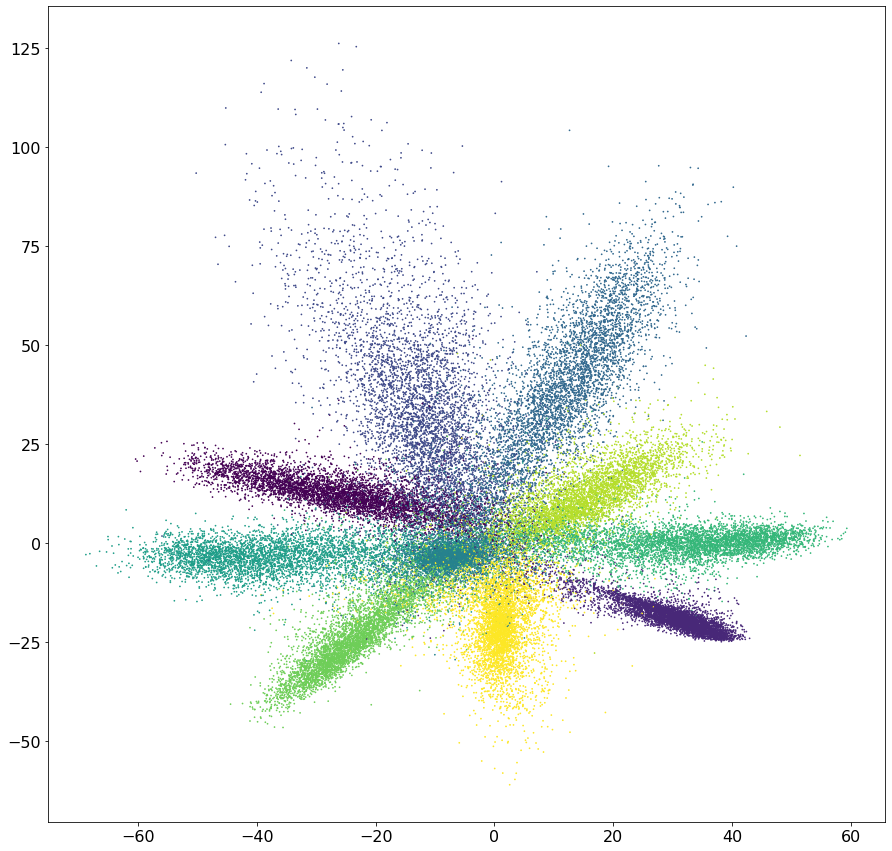

In [31]:

plt.figure(figsize=(15, 15))
plt.scatter(embed[:,0],embed[:,1], s=0.5, c=np.argmax(trainY, axis=1))

In [23]:
print('GPUs Available:', tf.config.list_physical_devices('GPU'))

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


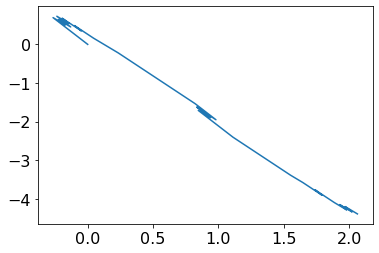

In [45]:
plt.plot(img_trainX[900,:,0], img_trainX[900,:,1])

In [6]:
def evaluate_model(trainX, trainY, testX, testY):
    '''
    The model is fit for a fixed number of epochs, in this case 10, and a batch size of 32 samples will be used,
    where 32 windows of data will be exposed to the model before the weights of the model are updated
    '''
    verbose, epochs, batch_size = 0, 10, 32
    #n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    '''
    For this model, we will use a standard configuration of 64 parallel feature maps and a kernel size of 3. 
    The feature maps are the number of times the input is processed or interpreted,
    whereas the kernel size is the number of input time steps considered as the input sequence is read or processed onto the feature maps.
    '''
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5)) # For regularization - intended to help slow down the learning process and hopefully result in a better final model
    model.add(MaxPooling1D(pool_size=2)) #Reduces the learned features to 1/4 their size, consolidating them to only the most essential elements
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    # Categorical cross entropy loss function will be used given that we are learning a multi-class classification problem
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
    return accuracy

In [7]:
# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print('Param=%s: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)

In [8]:
scores = list()
for r in range(10):
    score = evaluate_model(trainX, trainY, testX, testY)
    score = score * 100.0
    print('>#%d: %.3f' % (r+1, score))
    scores.append(score)
# summarize results
summarize_results(scores)

>#1: 95.710
>#2: 95.210


KeyboardInterrupt: 

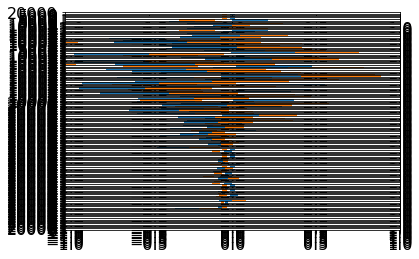

In [12]:
# Can we improve it? We'll use scaling
pyplot.figure()
xaxis = None
for i in range(flatTrainX.shape[1]):
    ax = pyplot.subplot(flatTrainX.shape[1], 1, i+1, sharex=xaxis)
    ax.set_xlim(-1, 1)
    if i == 0:
        xaxis = ax
    pyplot.hist(flatTrainX[:, i], bins=50)
pyplot.show()

In [8]:
flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
flatTestX  = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
print(flatTrainX.shape)
print(flatTestX.shape)

(2560000, 2)
(1280000, 2)


In [10]:
s = StandardScaler()
flatTrainX = s.fit_transform(flatTrainX)
flatTestX = s.fit_transform(flatTestX)
print(flatTrainX.shape)
print(flatTestX.shape)

(2560000, 2)
(1280000, 2)


In [11]:
flatTrainX = flatTrainX.reshape((trainX.shape))
flatTestX = flatTestX.reshape((testX.shape))
print(flatTrainX.shape)
print(flatTestX.shape)

(20000, 128, 2)
(10000, 128, 2)


In [8]:
def scaleData(trainX,testX, standardize):
    flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
    flatTestX  = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
    if standardize:
        s = StandardScaler()
        flatTrainX = s.fit_transform(flatTrainX)
        flatTestX = s.fit_transform(flatTestX)
    # reshape
    flatTrainX = flatTrainX.reshape((trainX.shape))
    flatTestX = flatTestX.reshape((testX.shape))
    return flatTrainX, flatTestX

In [9]:
def evaluate_model(trainX, trainy, testX, testy, param):
    '''
    The model is fit for a fixed number of epochs, in this case 10, and a batch size of 32 samples will be used,
    where 32 windows of data will be exposed to the model before the weights of the model are updated
    '''
    verbose, epochs, batch_size = 0, 10, 32
    #n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # scale data
    trainX, testX = scaleData(trainX, testX, param)
    model = Sequential()
    '''
    For this model, we will use a standard configuration of 64 parallel feature maps and a kernel size of 3. 
    The feature maps are the number of times the input is processed or interpreted,
    whereas the kernel size is the number of input time steps considered as the input sequence is read or processed onto the feature maps.
    '''
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5)) # For regularization - intended to help slow down the learning process and hopefully result in a better final model
    model.add(MaxPooling1D(pool_size=2)) #Reduces the learned features to 1/2 their size, consolidating them to only the most essential elements
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    # Categorical cross entropy loss function will be used given that we are learning a multi-class classification problem
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [10]:
def run_experiment(params, repeats=10):
    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainY, testX, testY, p)
            score = score * 100.0
            print('>p=%s #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)

>p=False #1: 95.630
>p=False #2: 95.890
>p=False #3: 95.750
>p=False #4: 95.420
>p=False #5: 95.700
>p=False #6: 95.590
>p=False #7: 95.230
>p=False #8: 95.690
>p=False #9: 95.630
>p=False #10: 95.100
>p=True #1: 95.830
>p=True #2: 95.410
>p=True #3: 95.560
>p=True #4: 94.960
>p=True #5: 95.450
>p=True #6: 95.950
>p=True #7: 95.470
>p=True #8: 95.270
>p=True #9: 95.680
>p=True #10: 95.750
[[95.63000202178955, 95.8899974822998, 95.74999809265137, 95.4200029373169, 95.70000171661377, 95.59000134468079, 95.23000121116638, 95.69000005722046, 95.63000202178955, 95.09999752044678], [95.8299994468689, 95.41000127792358, 95.56000232696533, 94.95999813079834, 95.45000195503235, 95.95000147819519, 95.46999931335449, 95.27000188827515, 95.67999839782715, 95.74999809265137]] [False, True]
Param=False: 95.563% (+/-0.231)
Param=True: 95.533% (+/-0.275)


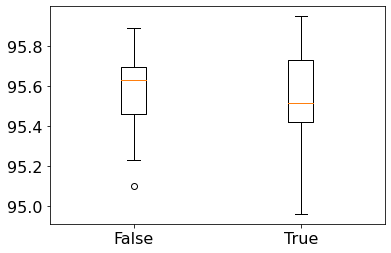

In [11]:
n_params = [False, True]
run_experiment(n_params)

(2560000, 2)
(1280000, 2)


In [147]:
flatTrainX[:,1]

array([-0.08933354, -0.08933354, -1.85690637, ..., -0.08933354,
       -0.08933354, -0.08933354])